                 open       high        low      close       volume
datetime                                                           
2019-01-02   20.41000   21.01000   19.92000   20.67000  174879888.0
2019-01-03   20.47000   20.63000   19.83000   20.02000  104477864.0
2019-01-04   20.40000   21.20000   20.18000   21.18000  110911848.0
2019-01-07   21.45000   22.45000   21.18000   22.33000  113268488.0
2019-01-08   22.80000   22.93000   21.80000   22.36000  105127848.0
...               ...        ...        ...        ...          ...
2023-09-11  264.26999  274.85001  260.60999  273.57999  174667900.0
2023-09-12  270.76001  278.39001  266.60001  267.48001  135999900.0
2023-09-13  270.07001  274.98001  268.10001  271.29999  111673700.0
2023-09-14  271.32001  276.70999  270.42001  276.04001  107298900.0
2023-09-15  278.80579  278.98001  271.00000  274.41000  119957291.0

[1185 rows x 5 columns]
                 open       high        low      close       volume  \
datetime            

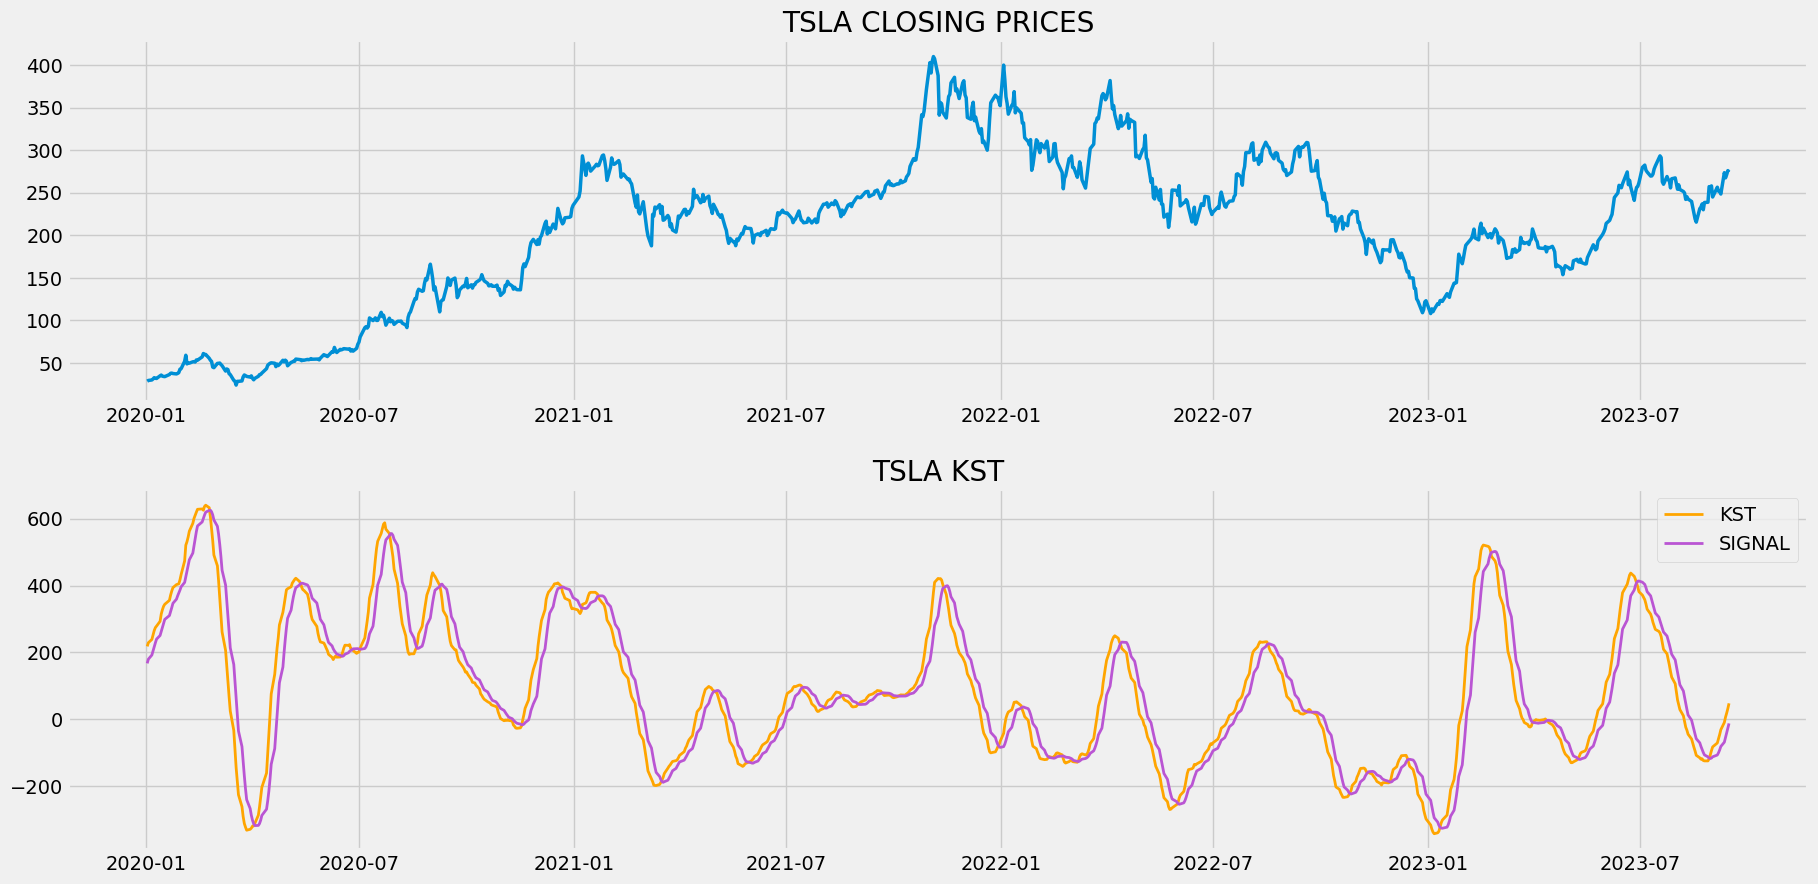

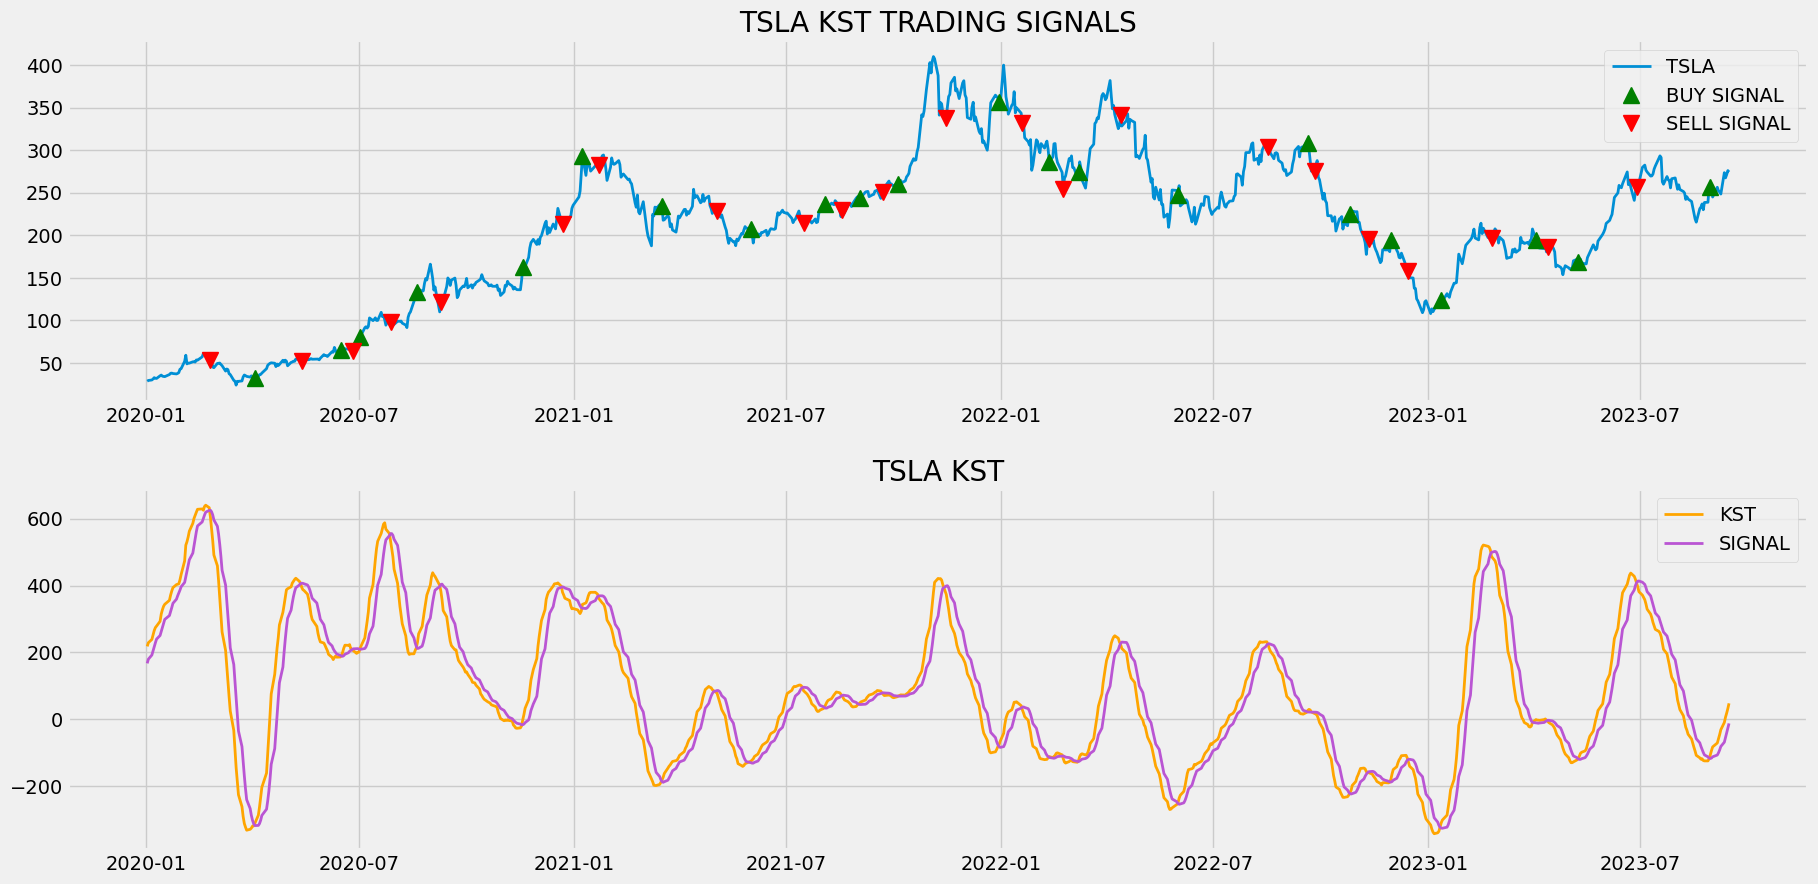

                close         kst  signal_line  kst_signal  kst_position
datetime                                                                
2020-01-02   28.68000  218.210543   167.457645           0             1
2020-01-03   29.53000  229.102232   179.983178           0             1
2020-01-06   30.10000  239.075722   192.410187           0             1
2020-01-07   31.27000  252.664975   204.805603           0             1
2020-01-08   32.81000  265.472940   217.259890           0             1
...               ...         ...          ...         ...           ...
2023-09-11  273.57999   -9.172467   -68.062932           0             1
2023-09-12  267.48001    6.675832   -54.281198           0             1
2023-09-13  271.29999   18.901554   -40.414064           0             1
2023-09-14  276.04001   32.476390   -26.449500           0             1
2023-09-15  274.41000   47.995956   -11.981729           0             1

[933 rows x 5 columns]
            close         k

In [1]:
# IMPORTING PACKAGES

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from math import floor
from termcolor import colored as cl

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)


# EXTRACTING STOCK DATA

def get_historical_data(symbol, start_date):
    api_key = 'f9b5e68f0ed44209bcbb9253b2f8b3b6'
    api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&outputsize=5000&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['values']).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)
    return df

tsla = get_historical_data('TSLA', '2019-01-01')
print(tsla)


# ROC CALCULATION

def get_roc(close, n):
    difference = close.diff(n)
    nprev_values = close.shift(n)
    roc = (difference / nprev_values) * 100
    return roc


# KST CALCULATION

def get_kst(close, sma1, sma2, sma3, sma4, roc1, roc2, roc3, roc4, signal):
    rcma1 = get_roc(close, roc1).rolling(sma1).mean()
    rcma2 = get_roc(close, roc2).rolling(sma2).mean()
    rcma3 = get_roc(close, roc3).rolling(sma3).mean()
    rcma4 = get_roc(close, roc4).rolling(sma4).mean()
    kst = (rcma1 * 1) + (rcma2 * 2) + (rcma3 * 3) + (rcma4 * 4)
    signal = kst.rolling(signal).mean()
    return kst, signal

tsla['kst'], tsla['signal_line'] = get_kst(tsla['close'], 10, 10, 10, 15, 10, 15, 20, 30, 9)
tsla = tsla[tsla.index >= '2020-01-01']
print(tsla.tail())


# KST INDICATOR PLOT

ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(tsla['close'], linewidth = 2.5)
ax1.set_title('TSLA CLOSING PRICES')
ax2.plot(tsla['kst'], linewidth = 2, label = 'KST', color = 'orange')
ax2.plot(tsla['signal_line'], linewidth = 2, label = 'SIGNAL', color = 'mediumorchid')
ax2.legend()
ax2.set_title('TSLA KST')
plt.show()


# KST CROSSOVER TRADING STRATEGY

def implement_kst_strategy(prices, kst_line, signal_line):
    buy_price = []
    sell_price = []
    kst_signal = []
    signal = 0

    for i in range(len(kst_line)):

        if kst_line[i-1] < signal_line[i-1] and kst_line[i] > signal_line[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kst_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kst_signal.append(0)

        elif kst_line[i-1] > signal_line[i-1] and kst_line[i] < signal_line[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kst_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kst_signal.append(0)

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kst_signal.append(0)

    return buy_price, sell_price, kst_signal

buy_price, sell_price, kst_signal = implement_kst_strategy(tsla['close'], tsla['kst'], tsla['signal_line'])


# TRADING SIGNALS PLOT

ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(tsla['close'], linewidth = 2, label = 'TSLA')
ax1.plot(tsla.index, buy_price, marker = '^', markersize = 12, linewidth = 0, color = 'green', label = 'BUY SIGNAL')
ax1.plot(tsla.index, sell_price, marker = 'v', markersize = 12, linewidth = 0, color = 'r', label = 'SELL SIGNAL')
ax1.legend()
ax1.set_title('TSLA KST TRADING SIGNALS')
ax2.plot(tsla['kst'], linewidth = 2, label = 'KST', color = 'orange')
ax2.plot(tsla['signal_line'], linewidth = 2, label = 'SIGNAL', color = 'mediumorchid')
ax2.legend()
ax2.set_title('TSLA KST')
plt.show()


# STOCK POSITION

position = []
for i in range(len(kst_signal)):
    if kst_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)

for i in range(len(tsla['close'])):
    if kst_signal[i] == 1:
        position[i] = 1
    elif kst_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]

close_price = tsla['close']
kst = tsla['kst']
signal_line = tsla['signal_line']
kst_signal = pd.DataFrame(kst_signal).rename(columns = {0:'kst_signal'}).set_index(tsla.index)
position = pd.DataFrame(position).rename(columns = {0:'kst_position'}).set_index(tsla.index)

frames = [close_price, kst, signal_line, kst_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

print(strategy)
print(strategy[35:40])


# BACKTESTING

tsla_ret = pd.DataFrame(np.diff(tsla['close'])).rename(columns = {0:'returns'})
kst_strategy_ret = []

for i in range(len(tsla_ret)):
    returns = tsla_ret['returns'][i]*strategy['kst_position'][i]
    kst_strategy_ret.append(returns)

kst_strategy_ret_df = pd.DataFrame(kst_strategy_ret).rename(columns = {0:'kst_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/tsla['close'][0])
kst_investment_ret = []

for i in range(len(kst_strategy_ret_df['kst_returns'])):
    returns = number_of_stocks*kst_strategy_ret_df['kst_returns'][i]
    kst_investment_ret.append(returns)

kst_investment_ret_df = pd.DataFrame(kst_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(kst_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the KST strategy by investing $100k in TSLA : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the KST strategy : {}%'.format(profit_percentage), attrs = ['bold']))


# SPY ETF COMPARISON

def get_benchmark(start_date, investment_value):
    spy = get_historical_data('SPY', start_date)['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})

    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []

    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('KST Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))